#Laptop Price Prediction: A Data-Driven Valuation Analysis

## 1. Project Overview & Objective

### 1.1 Context
In the competitive consumer electronics market, laptop pricing is influenced by a complex interplay of hardware specifications, brand positioning, and form factors. For consumers and retailers alike, determining the "fair market value" of a device based solely on its technical sheet can be challenging due to the non-linear value added by specific components (e.g., the price jump from 8GB to 16GB RAM is not always proportional).

### 1.2 Objective
This project aims to build an end-to-end machine learning pipeline that:
- **Predicts laptop prices** using structured product specification data.
- **Identifies key pricing drivers** through interpretable model insights.
- **Analyzes market structure** by uncovering clusters of similarly positioned devices.

By combining prediction and interpretation, the project can support more transparent pricing guidance in retail and consumer decision-making.

### 1.3 Problem Definition
We define this task as a **Supervised Regression Problem**.
* **Supervised:** We are training the model using a labeled dataset where the target variable, the laptop market price (Price_euros), is known.
* **Regression:** The target variable, `Price_euros`, is a **continuous numerical value**.

### 1.4 Analytical Approach
To ensure a rigorous analysis, our strategy proceeds in five phases:
1. **Data Preprocessing**
2. **Exploratory Data Analysis (EDA)**: In addition to correlation analysis, we apply exploratory logistic regression by binarizing the price variable to gain insights into feature importance and directional relationships. Unsupervised learning techniques such as PCA and K-Means are further used to analyze structural patterns in the data.

3. **Predictive Modeling**: We establish baseline regression performance using regularized linear models (Lasso and Ridge Regression). We then build an XGBoost regression model to further enhance predictive accuracy.
4. **Model Comparison**: We compare model performance using standard regression evaluation metrics.
5. **Conclusion**

## 2. Data Preprocessing

To ensure data quality and prepare the dataset for machine learning models, we performed the following preprocessing steps in a separate notebook (`Preprocessing.ipynb`) in Appendix:

* **Missing Value Check:** We conducted a thorough inspection of the dataset and confirmed there were **no missing values** across any columns. Consequently, no imputation techniques were required, preserving the original data integrity.
* **One-Hot Encoding:** Categorical variables (e.g., `Company`, `TypeName`, `GPU_model`) were transformed into numerical format using **One-Hot Encoding** (`pd.get_dummies`).
* **Train-Test Split:** The dataset was split into training (80%) and testing (20%) sets with a fixed `random_state=42` to ensure reproducibility.
* **Feature Scaling:** We applied **Min-Max Scaling** to numerical features (e.g., `Inches`, `Ram`, `Weight`) to normalize values between 0 and 1. To prevent **data leakage**, the scaler was **fitted only on the training set** and then used to transform the test set.

In [ ]:
import pandas as pd
import numpy as np

# Load the pre-processed datasets (Encoded & Scaled)
# These files were generated in the 'Preprocessing.ipynb' in Appendix
X_train = pd.read_csv('X_train_scaled.csv')
X_test = pd.read_csv('X_test_scaled.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

# Verify the shapes
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Display the first few rows to verify scaling
display(X_train.head())

Training set shape: (1020, 874)
Test set shape: (255, 874)


,Inches,Ram,Weight,ScreenW,ScreenH,CPU_freq,PrimaryStorage,SecondaryStorage,Company_Apple,Company_Asus,...,GPU_model_Radeon R7 M440,GPU_model_Radeon R7 M445,GPU_model_Radeon R7 M460,GPU_model_Radeon R7 M465,GPU_model_Radeon R9 M385,GPU_model_Radeon RX 540,GPU_model_Radeon RX 550,GPU_model_Radeon RX 560,GPU_model_Radeon RX 580,GPU_model_UHD Graphics 620
0,0.385542,0.096774,0.226933,0.223929,0.224138,0.592593,0.121569,0.0,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0.469880,0.225806,0.314214,0.223929,0.224138,0.703704,0.247059,0.0,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0.662651,0.032258,0.351621,0.223929,0.224138,0.518519,0.121569,0.0,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0.662651,0.096774,0.376559,0.223929,0.224138,0.666667,0.498039,0.0,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0.662651,0.032258,0.291771,0.223929,0.224138,0.407407,0.498039,0.0,False,False,...,False,False,False,False,False,False,False,False,False,False


##3. Exploratory Data Analysis (EDA)



###3.1 Target Variable Analysis: Price Distribution
  First, we examine the distribution of Price_euros.

In [ ]:
y_train.describe()

,Price_euros
count,1020.000000
mean,0.160454
std,0.118047
min,0.000000
25%,0.070042
50%,0.135696
75%,0.221658
max,0.898734


(array([133., 206., 167., 163., 113.,  64.,  64.,  42.,  27.,  19.,  10.,
          4.,   1.,   2.,   2.,   1.,   0.,   1.,   0.,   1.]),
 array([0.        , 0.04493671, 0.08987342, 0.13481013, 0.17974684,
        0.22468354, 0.26962025, 0.31455696, 0.35949367, 0.40443038,
        0.44936709, 0.4943038 , 0.53924051, 0.58417722, 0.62911392,
        0.67405063, 0.71898734, 0.76392405, 0.80886076, 0.85379747,
        0.89873418]),
 <BarContainer object of 20 artists>)

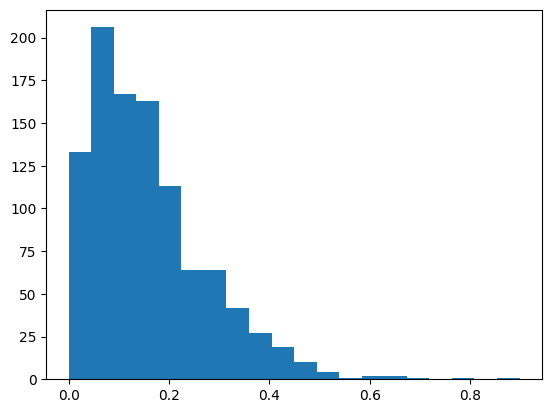

In [ ]:
import matplotlib.pyplot as plt
import plotly.express as px
plt.hist(y_train,20)

**Key Observation:**

The price distribution is **right-skewed**. This suggests that a **Log Transformation** ($\log(1+y)$) is necessary during the modeling phase to satisfy the normality assumption of linear regression.

In [ ]:
# Applying log transformation
# Since the price data is already scaled (0~1), log(1+y) is the most common and safest transformation method.
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

###3.2 Multicollinearity Check
We examine the correlations between numerical features to check if there's **multicollinearity** between variables.

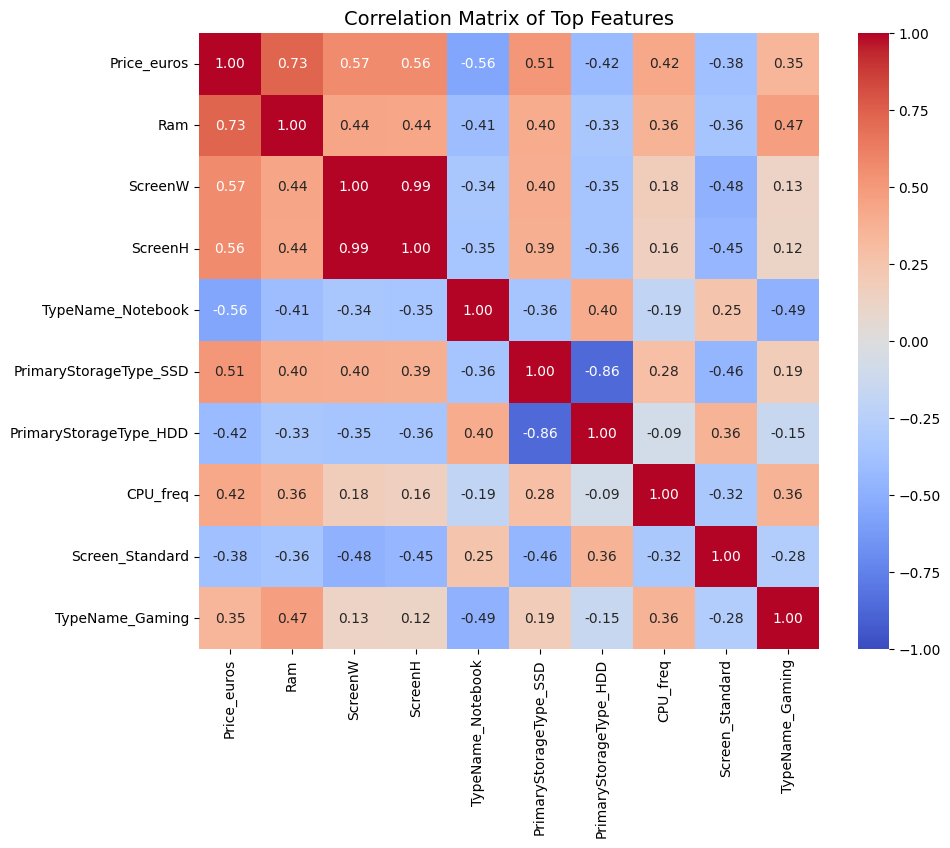

In [ ]:
import seaborn as sns
correlations = pd.concat([y_train, X_train], axis=1).corr()
top_corr_features = correlations['Price_euros'].abs().sort_values(ascending=False).head(10).index
plt.figure(figsize=(10, 8))
sns.heatmap(correlations.loc[top_corr_features, top_corr_features],
            annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Top Features', fontsize=14)
plt.show()

**Key Observation**:

ScreenW and ScreenH are almost perfectly correlated (r ≈ 0.99), indicating strong multicollinearity among screen dimension features.
This suggests that these variables capture largely redundant information.

**Multicollinearity in Physical Specifications**

While features such as `Inches` and `Weight` did not appear in the above correlation heatmap due to their low direct correlation with `Price_euros`, physical considerations suggest that these variables may be strongly correlated with one another. We isolate these physical specifications to explicitly examine multicollinearity.

In [ ]:
# Select specific physical features + Price for context
physical_features = ['Inches', 'Weight', 'ScreenW', 'ScreenH', 'Price_euros']

# Extract the correlation subset

phys_corr_table = correlations.loc[physical_features, physical_features]
print("Correlation Matrix (Physical Specifications):")
display(phys_corr_table.round(4))

Correlation Matrix (Physical Specifications):


,Inches,Weight,ScreenW,ScreenH,Price_euros
Inches,1.0000,0.8265,-0.0771,-0.1000,0.0457
Weight,0.8265,1.0000,-0.0336,-0.0531,0.1789
ScreenW,-0.0771,-0.0336,1.0000,0.9947,0.5676
ScreenH,-0.1000,-0.0531,0.9947,1.0000,0.5642
Price_euros,0.0457,0.1789,0.5676,0.5642,1.0000


**Key Observations:**
- **Inches vs. Weight (r = 0.8265)**: This strong positive correlation indicates that larger laptops tend to be heavier. While `Inches` shows minimal direct correlation with price (r = 0.0457), it is highly collinear with `Weight`, which may affect coefficient stability in linear models.
- **ScreenW vs. ScreenH (r = 0.9947)**: The near-perfect correlation indicates severe multicollinearity, suggesting that these variables capture largely redundant information about screen dimensions.

Overall, the physical specification features exhibit substantial multicollinearity, which motivates us to use of regularization in linear regression model.


###3.3 Regularization Diagnosis (Ridge vs. Lasso)

Beyond correlation analysis, we apply exploratory **logistic regression** on a binary price target (high-end vs. budget) with L1 (Lasso) and L2 (Ridge) regularization to examine feature stability under penalization. This allows us to assess feature relevance and redundancy in the presence of multicollinearity.

- **Ridge (L2):** Retains all features while shrinking coefficients, making it effective for handling collinearity but preserving redundant information.

- **Lasso (L1):** Encourages sparsity by driving weak or redundant feature coefficients to zero, thereby providing implicit feature selection.


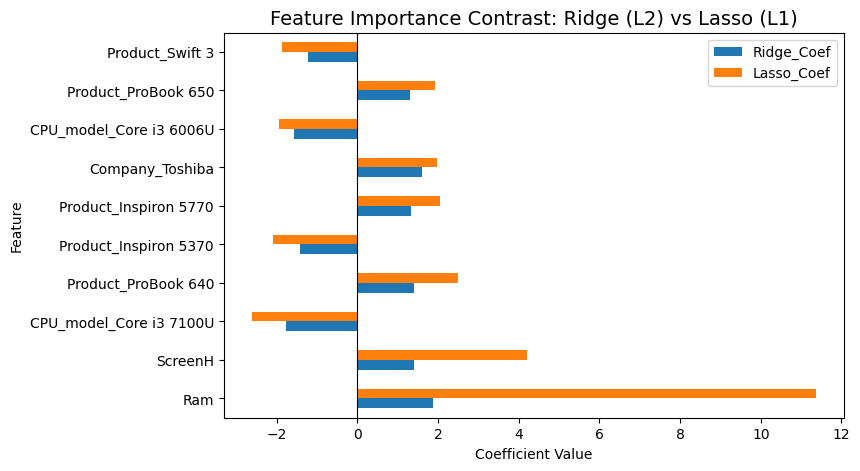

,Ridge_Coef,Lasso_Coef
Feature,,
Ram,1.870438,11.358808
ScreenH,1.398815,4.203770
CPU_model_Core i3 7100U,-1.767055,-2.615853
Product_ProBook 640,1.402120,2.483078
Product_Inspiron 5370,-1.417632,-2.097585
Product_Inspiron 5770,1.315558,2.050746
Company_Toshiba,1.596192,1.976251
CPU_model_Core i3 6006U,-1.568206,-1.943885
Product_ProBook 650,1.308650,1.926077


In [ ]:
from sklearn.linear_model import LogisticRegression

# Transform into a binary classification task (High-end vs. Budget)
median_price = y_train['Price_euros'].median()
y_train_binary = (y_train['Price_euros'] >= median_price).astype(int)

# Train Ridge (L2) and Lasso (L1) Logistic Regression models
model_l2 = LogisticRegression(penalty='l2', solver='liblinear', C=1.0).fit(X_train, y_train_binary)
model_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=1.0).fit(X_train, y_train_binary)

# Extract coefficients for comparison
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Ridge_Coef': model_l2.coef_[0],
    'Lasso_Coef': model_l1.coef_[0]
}).set_index('Feature')

# Sort by absolute Lasso coefficient to identify top 10 most influential features
coef_df['Abs_Lasso'] = coef_df['Lasso_Coef'].abs()
coef_view = coef_df.sort_values(by='Abs_Lasso', ascending=False).drop('Abs_Lasso', axis=1).head(10)

# Visualize the comparison
coef_view[['Ridge_Coef', 'Lasso_Coef']].plot(kind='barh', figsize=(8, 5))
plt.title('Feature Importance Contrast: Ridge (L2) vs Lasso (L1)', fontsize=14)
plt.xlabel('Coefficient Value')
plt.axvline(0, color='black', linewidth=0.8)
plt.show()

display(coef_view)

**Key Observations**:

- Lasso concentrates explanatory power on a small number of dominant features, most notably **Ram**.
- Ridge distributes weights evenly across correlated variables, while Lasso highlights a sparse structure in which memory capacity emerges as the primary driver distinguishing high-end and budget laptops.

###3.4 Principal Components Analysis (PCA)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Extract numerics features for PCA only
numeric_cols = [
    "Inches",
    "Ram",
    "Weight",
    "ScreenW",
    "ScreenH",
    "CPU_freq",
    "PrimaryStorage",
    "SecondaryStorage"
]

X_train_num = X_train[numeric_cols].copy()
X_test_num = X_test[numeric_cols].copy()

print(X_train_num.shape, X_test_num.shape)

# Standardization for PCA (preprocessing applied min–max scaling only)
scaler_pca = StandardScaler()

X_train_num_std = scaler_pca.fit_transform(X_train_num)
X_test_num_std = scaler_pca.transform(X_test_num)

print("Standardized numeric train shape:", X_train_num_std.shape)
print("Standardized numeric test shape:", X_test_num_std.shape)

(1020, 8) (255, 8)
Standardized numeric train shape: (1020, 8)
Standardized numeric test shape: (255, 8)


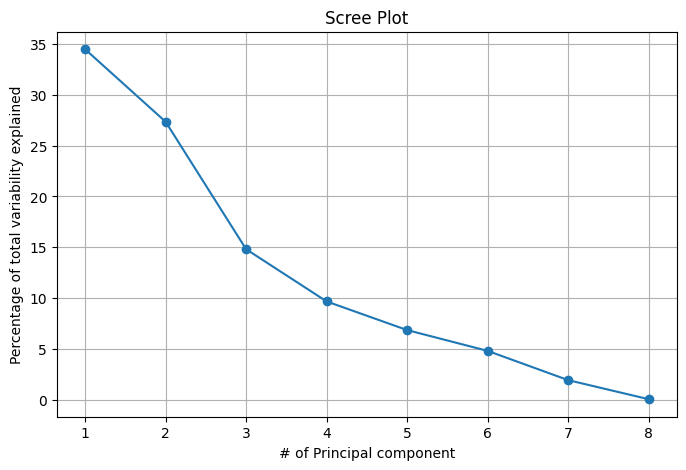

PC1: explained variance = 0.3448, cumulative = 0.3448
PC2: explained variance = 0.2735, cumulative = 0.6183
PC3: explained variance = 0.1481, cumulative = 0.7664
PC4: explained variance = 0.0968, cumulative = 0.8632
PC5: explained variance = 0.0686, cumulative = 0.9318
PC6: explained variance = 0.0481, cumulative = 0.9800
PC7: explained variance = 0.0194, cumulative = 0.9994
PC8: explained variance = 0.0006, cumulative = 1.0000


In [ ]:
# PCA variance decomposition
pca_numeric = PCA()
pca_numeric.fit(X_train_num_std)

explained_var = pca_numeric.explained_variance_ratio_
cum_explained_var = np.cumsum(explained_var)

# Scree plot visualization
num_explained_var = pca_numeric.explained_variance_ratio_

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(num_explained_var) + 1),
         num_explained_var * 100,
         marker="o")
plt.xlabel("# of Principal component")
plt.ylabel("Percentage of total variability explained")
plt.title("Scree Plot")
plt.grid(True)
plt.show()
for i, (var, cum) in enumerate(zip(explained_var, cum_explained_var), start=1):
    print(f"PC{i}: explained variance = {var:.4f}, cumulative = {cum:.4f}")

In [ ]:
# Extract first 2 PCs for clustering
X_train_pca_all = pca_numeric.transform(X_train_num_std)
X_test_pca_all = pca_numeric.transform(X_test_num_std)

X_train_pca_2d = X_train_pca_all[:, :2]
X_test_pca_2d = X_test_pca_all[:, :2]

print("Train PCA 2D shape:", X_train_pca_2d.shape)
print("Test PCA 2D shape:", X_test_pca_2d.shape)

Train PCA 2D shape: (1020, 2)
Test PCA 2D shape: (255, 2)


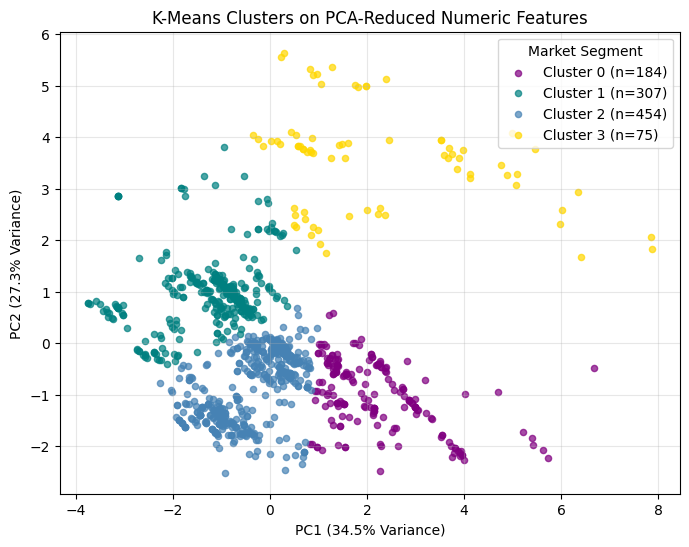

In [ ]:
# K-mean clustering with K=4
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(X_train_pca_2d)

# Visualization with legend
plt.figure(figsize=(8, 6))
colors = ['purple', 'teal', 'steelblue', 'gold']
labels = np.unique(cluster_labels)

for i, label in enumerate(labels):
    # Filter data points belonging to the current cluster
    mask = (cluster_labels == label)
    plt.scatter(
        X_train_pca_2d[mask, 0],
        X_train_pca_2d[mask, 1],
        label=f'Cluster {label} (n={np.sum(mask)})',
        c=colors[i],
        s=20,
        alpha=0.7
    )

var_ratio = pca_numeric.explained_variance_ratio_
plt.xlabel(f"PC1 ({var_ratio[0]:.1%} Variance)")
plt.ylabel(f"PC2 ({var_ratio[1]:.1%} Variance)")
plt.title("K-Means Clusters on PCA-Reduced Numeric Features")
plt.legend(title="Market Segment", loc='best') # Add legend
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Merge Cluster results back to the original dataset for analysis
# Using X_train index for alignment to ensure data integrity
df_analysis = pd.DataFrame({'Cluster': cluster_labels, 'Log_Price': y_train_log.values.ravel()})

# Calculate average price (Log Scale) for each cluster
# This helps identify if specific clusters represent "Budget" or "High-End" devices
print("Cluster Average Prices (Log Scale):")
print(df_analysis.groupby('Cluster')['Log_Price'].mean().sort_values(ascending=False))

Cluster Average Prices (Log Scale):
Cluster
3    0.284447
0    0.210090
1    0.148327
2    0.091092
Name: Log_Price, dtype: float64


**Key Observation**:

1. **Hierarchical Price Structure Identified**: Through K-Means clustering on the PCA-reduced features, we identified **four distinct market segments** that align perfectly with pricing tiers:

  - **Cluster 3 (Yellow, n=75)** - The Premium Tier: This cluster has the highest average log price (0.28). Its sparse distribution and separation from the main cluster suggest these are specialized, high-performance devices (e.g., Gaming Laptops or Workstations).

  - **Cluster 0 (Purple, n=184)** - Mid-High Range: With the second-highest average price (0.21), this group likely represents premium ultrabooks or business-class laptops.

  - **Cluster 1 (Green, n=307)** – Mainstream Segment: This cluster occupies an intermediate position in both price (average log price of 0.15) and PCA space. Its dense distribution and proximity to the budget cluster suggest that it represents mainstream consumer laptops offering moderate specifications at accessible price points.

  - **Cluster 2 (Blue, n=454)** - The Budget Segment: This is the largest cluster (45% of data) with the lowest average price (0.09), representing the mass market of entry-level and budget notebooks.

2. **Geometric Interpretation**: The 2D PCA plot visually confirms that the "Budget" (Blue) and "Mainstream" (Green) segments form a dense, continuous cloud, while the "Premium" (Yellow) segment is geometrically distinct.

3. **Modeling Implication**: This clear segmentation validates the necessity of using non-linear models like XGBoost. A simple linear regression might struggle to capture the pricing jump between the dense "Budget" cloud and the distinct "Premium" outliers.

##4. Predictive Modeling

###4.1 Baseline Model: Linear Regression with L2 regularization
Before introducing more complex models, we first evaluate a linear regression model as a baseline.



For consistency in model comparison, we first define a function to compute standard evaluation metrics.


In [ ]:
# evaluation function
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def model_performance(model_name, y_true_train, y_pred_train, y_true_test, y_pred_test):
    #train metrics
    mse_train = mean_squared_error(y_true_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    mae_train = mean_absolute_error(y_true_train, y_pred_train)
    r2_train = r2_score(y_true_train, y_pred_train)

    #test metrics
    mse_test = mean_squared_error(y_true_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    mae_test = mean_absolute_error(y_true_test, y_pred_test)
    r2_test = r2_score(y_true_test, y_pred_test)

    print(f"=== {model_name} ===")
    print("Train:")
    print(f"  MSE  = {mse_train:.4f}")
    print(f"  RMSE = {rmse_train:.4f}")
    print(f"  MAE  = {mae_train:.4f}")
    print(f"  R^2  = {r2_train:.4f}")
    print("Test:")
    print(f"  MSE  = {mse_test:.4f}")
    print(f"  RMSE = {rmse_test:.4f}")
    print(f"  MAE  = {mae_test:.4f}")
    print(f"  R^2  = {r2_test:.4f}")
    print()

We then fit linear regression models with and without regularization for baseline comparison.


In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

#============================================
#linear regression without regularization
#============================================
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train_log)

# Predict in log space
y_train_pred_lr_log = lin_reg.predict(X_train)
y_test_pred_lr_log = lin_reg.predict(X_test)

# Inverse Transformation (to original scale)
y_train_pred_lr = np.expm1(y_train_pred_lr_log)
y_test_pred_lr = np.expm1(y_test_pred_lr_log)

model_performance("Linear Regression (without regularization)", y_train.values.ravel(), y_train_pred_lr, y_test.values.ravel(), y_test_pred_lr)

#================================================
#linear regression with Ridge regularization
#================================================
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train, y_train_log.values.ravel())

# Predict in log space
y_train_pred_ridge_log = ridge_model.predict(X_train)
y_test_pred_ridge_log = ridge_model.predict(X_test)

# Inverse Transformation (to original scale)
y_train_pred_ridge = np.expm1(y_train_pred_ridge_log)
y_test_pred_ridge = np.expm1(y_test_pred_ridge_log)

model_performance("Ridge Regression (alpha = 1.0)", y_train.values.ravel(), y_train_pred_ridge, y_test.values.ravel(), y_test_pred_ridge)

#================================================
#linear regression with Lasso regularization
#================================================
lasso_model = Lasso(alpha=0.001, random_state=42, max_iter=10000)
lasso_model.fit(X_train, y_train_log.values.ravel())

# Predict in log space
y_train_pred_lasso_log = lasso_model.predict(X_train)
y_test_pred_lasso_log = lasso_model.predict(X_test)

# Inverse Transformation (to original scale)
y_train_pred_lasso = np.expm1(y_train_pred_lasso_log)
y_test_pred_lasso = np.expm1(y_test_pred_lasso_log)

model_performance("Lasso Regression (alpha = 0.001)", y_train.values.ravel(), y_train_pred_lasso, y_test.values.ravel(), y_test_pred_lasso)

=== Linear Regression (without regularization) ===
Train:
  MSE  = 0.0003
  RMSE = 0.0164
  MAE  = 0.0083
  R^2  = 0.9807
Test:
  MSE  = 0.2909
  RMSE = 0.5394
  MAE  = 0.0808
  R^2  = -19.5761

=== Ridge Regression (alpha = 1.0) ===
Train:
  MSE  = 0.0006
  RMSE = 0.0250
  MAE  = 0.0171
  R^2  = 0.9552
Test:
  MSE  = 0.0016
  RMSE = 0.0398
  MAE  = 0.0275
  R^2  = 0.8881

=== Lasso Regression (alpha = 0.001) ===
Train:
  MSE  = 0.0037
  RMSE = 0.0611
  MAE  = 0.0427
  R^2  = 0.7321
Test:
  MSE  = 0.0041
  RMSE = 0.0642
  MAE  = 0.0457
  R^2  = 0.7082



**Key Observation:**

The comparison of the three linear models demonstrates the importance of regularization in handling this high-dimensional dataset.

- **The Failure of Unregularized Linear Regression**: The Linear Regression (without regularization) model exhibited classic signs of severe overfitting:

  - **Excellent Training Performance**: The model achieved an outstanding $\mathbf{R^2}$ of $\mathbf{0.9807}$ on the training set. This high score confirms that the model was able to establish a near-perfect fit with the training data, largely due to the stabilizing effect of the $\text{log}$ transformation on the target variable.
  - **Memorizing Noise**: However, with 874 features, this high training $\text{R}^2$ indicates the model was memorizing noise and sample-specific fluctuations, rather than learning general patterns.
  - **Test Set Catastrophe**: Consequently, when fitting the testing data, the model's predictions completely collapsed, resulting in a negative $\mathbf{R^2}$ of $\mathbf{-19.5761}$.

- **The Success of Ridge Regression**: In contrast, the Ridge Regression model successfully mitigated these issues:

  - **Controlled Complexity**: By applying $\mathbf{L2}$ regularization, Ridge penalized large coefficient values, preventing the model from becoming overly complex and memorizing the training noise.
  - **Strong Generalization**: The performance gap between the training and test sets narrowed significantly: Training $\mathbf{R^2}$ was $\mathbf{0.9552}$ (still excellent), while testing $\mathbf{R^2}$ dramatically improved to $\mathbf{0.8881}$.

- The Lasso Regression also showed effective generalization, achieving a Test $\mathbf{R^2}$ of $\mathbf{0.7082}$, further supporting the necessity of regularization.

In summary, Ridge Regression serves as the stable and effective linear baseline for further comparison with the XGBoost champion model.

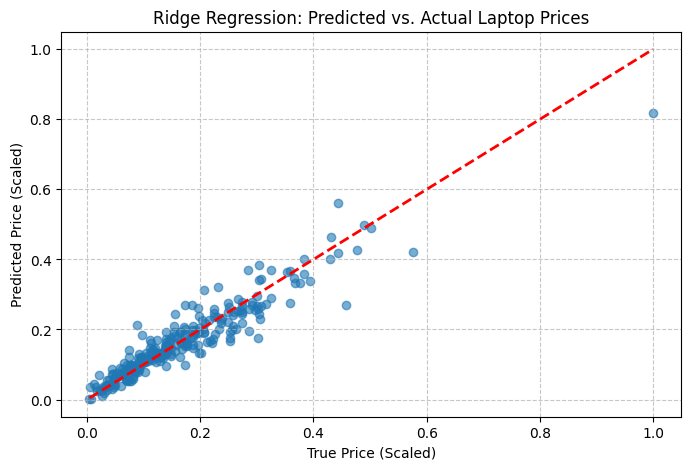

In [ ]:
# Create a scatter plot of true vs. predicted values
plt.figure(figsize=(8, 5))
plt.scatter(y_test.values.ravel(), y_test_pred_ridge, alpha=0.6)

# Add a diagonal line for perfect predictions (y=x)
plt.plot([y_test.min().item(), y_test.max().item()], [y_test.min().item(), y_test.max().item()],
         color='red', linestyle='--', lw=2, label='Perfect Prediction Line')

plt.title('Ridge Regression: Predicted vs. Actual Laptop Prices')
plt.xlabel('True Price (Scaled)')
plt.ylabel('Predicted Price (Scaled)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

###4.2 High-Performance Model: XGBoost Regressor

While our Ridge Regression (the baseline) proved robust by successfully using regularization to manage high dimensionality and collinearity, Ridge is fundamentally a linear model.

Based on the **high collinearity** observed during EDA between several features (e.g., ScreenW and ScreenH), and suspecting that the relationship between hardware specifications and price may involve **complex non-linear boundaries**, so we introduce the **XGBoost** (eXtreme Gradient Boosting) model.

Tree-based ensemble models like XGBoost offer distinct advantages:

- **Insensitivity to Collinearity**: They are generally unaffected by high correlation between features, which was an issue in our dataset.

- **Capture Non-linearity**: They naturally model non-linear relationships and feature interactions through their tree structure.

We anticipate that XGBoost will be able to push beyond the limits of the linear model, providing a more accurate price prediction

Note: We implement the best-performing XGBoost model in this section. The hyperparameter tuning process and our experiments incorporating PCA are documented in the appendix (xgboost.ipynb).

In [ ]:
def sanitize_col_names(df):
    cols = df.columns
    new_cols = []
    for col in cols:
        new_col = str(col).replace('[', '_').replace(']', '_').replace('<', '_').replace('>', '_').replace(' ', '_').replace(',', '')
        new_cols.append(new_col)
    df.columns = new_cols
    return df

# Sanitize column names for XGBoost compatibility using X_train_scaled and X_test_scaled
X_train_scaled = sanitize_col_names(X_train.copy())
X_test_scaled = sanitize_col_names(X_test.copy())

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

# Initialize XGBRegressor
xgb_regressor = XGBRegressor(random_state=42)

# Train the model with sanitized feature names and original continuous target
xgb_regressor.fit(X_train_scaled, y_train)
y_pred_train_xgb = xgb_regressor.predict(X_train_scaled)

# Predict on the test set
y_pred_test_xgb = xgb_regressor.predict(X_test_scaled)

model_performance( "XGBoost (without PCA)", y_train.values.ravel(), y_pred_train_xgb, y_test.values.ravel(), y_pred_test_xgb)

=== XGBoost (without PCA) ===
Train:
  MSE  = 0.0002
  RMSE = 0.0151
  MAE  = 0.0117
  R^2  = 0.9836
Test:
  MSE  = 0.0015
  RMSE = 0.0383
  MAE  = 0.0275
  R^2  = 0.8963



XGBoost achieves an $R^2$ of 0.8963 on the test set, suggesting improved ability to capture complex patterns in the data compared to the Ridge model.

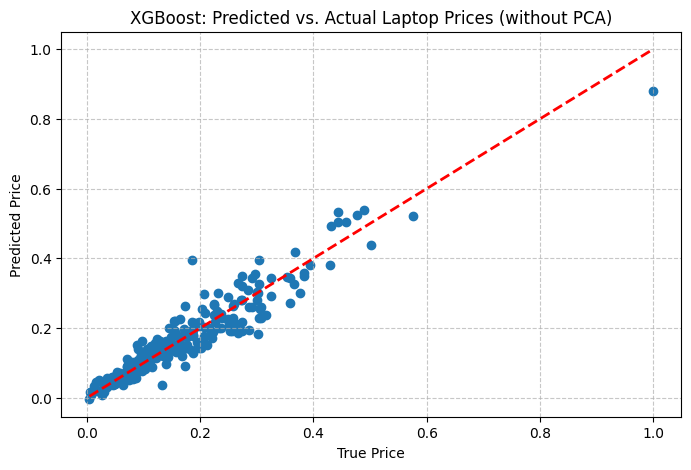

In [ ]:
# Create a scatter plot of true vs. predicted values
plt.figure(figsize=(8, 5))
plt.scatter(y_test.values.ravel(), y_pred_test_xgb)

# Add a diagonal line for perfect predictions (y=x)
plt.plot([y_test.min().item(), y_test.max().item()], [y_test.min().item(), y_test.max().item()],
         color='red', linestyle='--', lw=2, label='Perfect Prediction Line')

plt.title('XGBoost: Predicted vs. Actual Laptop Prices (without PCA)')
plt.xlabel('True Price')
plt.ylabel('Predicted Price')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

##5. Model Comparison
This table shows the performance of all models considered in this study, while additional models and experiments are provided in the appendix.


| Model | Linear Regression (No Regularization) | Ridge Regression | Lasso Regression | KNN | Random Forest | XGBoost | NN |
| :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| **MSE** | 0.2909 | 0.0016 | 0.0041 | 0.0021 | 0.00185 | 0.0015 | 0.0016 |
| **RMSE** | 0.5394 | 0.0398 | 0.0642 | 0.0463 | 0.04300 | 0.0383 | 0.0403 |
| **MAE** | 0.0808 | 0.0275 | 0.0457 | 0.0329 | 0.02906 | 0.0275 | 0.0275 |
| **R²** | -19.5761 | 0.8881 | 0.7082 | 0.8481 | 0.86922 | 0.8963 | 0.8849 |

##6. Conclusion
####**6.1 Data-Driven Insights & PCA Validation**
Before evaluating predictive models, our PCA and Clustering analysis provided critical insights into the market structure. We identified four distinct clusters, proving that the laptop market is not uniform but segmented:
- Market Segmentation: Specifically, Cluster 3 (High-End/Gaming) emerged as a distinct outlier group with the highest average price ($0.28$ log-scale), separating it from the mass-market "Budget" group (Cluster 2).
- Implication: This clear geometric separation suggested that a single global linear model might struggle to fit both budget and premium pricing strategies at the same time, indicating the need for non-linear modeling.
####**6.2 Model Performance Analysis**
Our modeling process demonstrated a clear hierarchy of performance, confirming our hypotheses about dimensionality and non-linearity.
- The Failure of Linear Regression (without Regularization)
  - The standard Linear Regression model gets a negative Test $R^2$ of -19.5761.
  - This collapse was due to severe overfitting caused by the high dimensionality of our dataset (874 features). The model memorized noise rather than learning patterns and was destabilized by multicollinearity (e.g., between ScreenW and ScreenH).
- The Success of Ridge Regression (L2 Regularization)
  - By simply adding L2 Regularization, Ridge Regression stabilized the model and achieved a high Test $R^2$ of 0.8881.
  - The regularization penalty successfully curbed model complexity, handling the sparse, high-dimensional data effectively.
- The Champion: XGBoost Regressor
  - XGBoost achieved the best overall performance with a Test $R^2$ of 0.8963 and the lowest RMSE of 0.0383. Its gradient boosting framework could model the non-linear price jumps associated with the "Premium Tier" (Cluster 3) that linear models tend to underestimate.
####**6.3 Final Verdict**

This project demonstrates that **XGBoost** is the most effective model for capturing complex pricing patterns in the premium laptop market, achieving the highest predictive performance on the test set ($R^2 = 0.8963$).

Under resource-constrained settings where model simplicity and interpretability are prioritized, **Ridge Regression** remains a strong baseline with competitive performance ($R^2 = 0.8881$). However, for this specific valuation task where minimizing prediction error is paramount, we select **XGBoost** as our final production model.
